<a href="https://colab.research.google.com/github/flediak/genIAL/blob/main/make_gal_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook shows how to model intrinsic galaxy shapes using genIAL, when information on host halo orientations is not avialable.
Galaxy orientations are thereby set to random.

# clone genIAL repository and import libraries

In [ ]:
! git clone https://github.com/flediak/genIAL.git

fatal: destination path 'genIAL' already exists and is not an empty directory.


In [ ]:
cd genIAL

/content/genIAL


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from genial import Galaxy, IntrinsicAlignment

# download input galaxy catalogue

In [22]:
!gdown 1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl -O input_file.parquet

#when not working on google colab use:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl' -O ../data/input_file.parquet

Downloading...
From: https://drive.google.com/uc?id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl
To: /content/genIAL/genIAL/input_file.parquet
100% 33.3M/33.3M [00:00<00:00, 196MB/s]


# download shape parameter file

In [17]:
!gdown 1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf -O ia_shape_parameters.csv

#when not working on google colab use:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf' -O ia_shape_parameters.csv

Downloading...
From: https://drive.google.com/uc?id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf
To: /content/genIAL/genIAL/ia_shape_parameters.csv
100% 2.00M/2.00M [00:00<00:00, 173MB/s]


# set up shape model parameters

In [18]:
# Hoffman et al. 2022 color cut for MICECAT2
ia_ur_cut = 0.94

# read input table with shape model parameters
with open('ia_shape_parameters.csv') as fd:
    ia_params = pd.read_csv(fd, header=0)
    ia_params.loc[ia_params['gal_color']==2.0, 'gal_color'] = Galaxy.Color.BLUE.value
    ia_params.loc[ia_params['gal_color']==0.0, 'gal_color'] = Galaxy.Color.RED.value
    ia_params = ia_params.set_index(['gal_color', 'z', 'mag']).sort_index()[['q_mean', 'r_mean', 'sigma']]

# instantiate IA class

In [19]:
ia = IntrinsicAlignment(ia_params)

# shape model pipeline

In [20]:
def make_shapes(df_in, ia_ur_cut):
    
    df = df_in.copy(deep=True)

    # use this color index for red blue definitions
    ia_ur = df['cfht_u_abs_mag'] - df['subaru_r_abs_mag']

    # define blue / red IDs
    ia_color = np.where(
        ia_ur < ia_ur_cut,
        Galaxy.Color.BLUE.value,
        Galaxy.Color.RED.value
    ).astype('i1')

    ### define satellite / central IDs
    ia_kind = np.where(
        cat.flag_central == 0,
        Galaxy.Kind.CENTRAL.value,
        Galaxy.Kind.SATELLITE.value
    ).astype('i1')


    ### ====== set 3D axis ratios ======
    df['q_gal'], df['s_gal'] = ia.axis_ratio(ia_color, df['true_redshift_gal'].values, df['subaru_r_abs_mag'].values)

    df['q_gal'] = df['q_gal'].astype('f4')
    df['s_gal'] = df['s_gal'].astype('f4')


    ### ====== set random galaxy positions and orientations ======

    #position
    vg = ia._random_vector(len(df))

    #major and minor axis
    Ag = ia._random_vector(len(df))
    Cg = ia._random_perpendicular(Ag)


    ### ====== get ellipticity ======
    qg = df['q_gal'].values.T
    sg = df['s_gal'].values.T

    df['eps1_gal'], df['eps2_gal'] = ia.ellipticity(vg, qg, sg, Ag, Cg)
    
    df['eps1_gal'] = df['eps1_gal'].astype('f4')
    df['eps2_gal'] = df['eps2_gal'].astype('f4')

    return df

# read input catalogue

In [23]:
cat = pd.read_parquet('input_file.parquet')#.iloc[0:1000]

In [25]:
print(len(cat))

229131


# make shapes

In [24]:
cat = make_shapes(cat, ia_ur_cut)

# plot 2D axis ratio distributions

In [26]:
eps_abs = (cat['eps1_gal']**2 + cat['eps2_gal']**2)**0.5
cat['q_proj'] = (1-eps_abs) / (1+eps_abs)

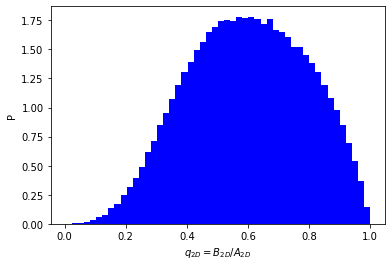

In [27]:
plt.hist(cat.q_proj, bins=50, density=True, color='b')

plt.xlabel(r'$q_{2D} = B_{2D}/A_{2D}$')
plt.ylabel('P')
plt.show()